In [259]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, LeakyReLU

from plotnine import *

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [260]:
url = 'https://raw.githubusercontent.com/min-is/nba/refs/heads/main/datasets/jaysontatum.csv'
df = pd.read_csv(url)
df = pd.get_dummies(df, columns = ["Opp"])

df = df.fillna(0)  # Replace NaNs
df = df.replace([np.inf, -np.inf], 0)

features = [col for col in df.columns if col != "PTS"]

df.head()
print(features)

['Ven', 'WinMar', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'GmSc', '+/-', 'TS%', 'eFG%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'ORtg', 'DRtg', 'BPM', 'Opp_ATL', 'Opp_BRK', 'Opp_CHI', 'Opp_CHO', 'Opp_CLE', 'Opp_DAL', 'Opp_DEN', 'Opp_DET', 'Opp_GSW', 'Opp_HOU', 'Opp_IND', 'Opp_LAC', 'Opp_LAL', 'Opp_MEM', 'Opp_MIA', 'Opp_MIL', 'Opp_MIN', 'Opp_NOP', 'Opp_NYK', 'Opp_OKC', 'Opp_ORL', 'Opp_PHI', 'Opp_PHO', 'Opp_POR', 'Opp_SAC', 'Opp_SAS', 'Opp_TOR', 'Opp_UTA', 'Opp_WAS']


In [284]:
X = df[features]
y = df["PTS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

z = StandardScaler()
X_train_scaled = z.fit_transform(X_train)
X_test_scaled = z.transform(X_test)

model = Sequential([
    Dense(1024, input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),

    Dense(512),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),

    Dense(256),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    
    Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),

    Dense(64),
    LeakyReLU(alpha=0.01),

    Dense(32),
    LeakyReLU(alpha=0.01),

    Dense(1)
])

# Use Adam optimizer with a small learning rate and beta values
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_260 (Dense)           (None, 1024)              67584     
                                                                 
 batch_normalization_23 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 leaky_re_lu_104 (LeakyReLU)  (None, 1024)             0         
                                                                 
 dropout_38 (Dropout)        (None, 1024)              0         
                                                                 
 dense_261 (Dense)           (None, 512)               524800    
                                                                 
 batch_normalization_24 (Bat  (None, 512)              2048      
 chNormalization)                                    

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-7)
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='mse', metrics=["mae"])

history = model.fit(
    X_train_scaled, y_train,
    epochs = 500,
    batch_size = 32,
    validation_data = (X_test_scaled, y_test),
    verbose = 1,
    callbacks = [lr_scheduler, early_stopping]
)

Epoch 1/2000
7/7 [==============================] - 2s 29ms/step - loss: 706.8929 - mae: 25.6307 - val_loss: 701.5256 - val_mae: 25.7147 - lr: 1.0000e-04
Epoch 2/2000
7/7 [==============================] - 0s 11ms/step - loss: 694.5723 - mae: 25.4362 - val_loss: 684.1154 - val_mae: 25.4254 - lr: 1.0000e-04
Epoch 3/2000
7/7 [==============================] - 0s 11ms/step - loss: 680.7083 - mae: 25.2291 - val_loss: 666.7261 - val_mae: 25.1283 - lr: 1.0000e-04
Epoch 4/2000
7/7 [==============================] - 0s 11ms/step - loss: 664.1807 - mae: 24.9654 - val_loss: 650.4553 - val_mae: 24.8433 - lr: 1.0000e-04
Epoch 5/2000
7/7 [==============================] - 0s 11ms/step - loss: 651.1316 - mae: 24.6883 - val_loss: 634.5016 - val_mae: 24.5573 - lr: 1.0000e-04
Epoch 6/2000
7/7 [==============================] - 0s 11ms/step - loss: 634.9274 - mae: 24.4448 - val_loss: 619.7018 - val_mae: 24.2856 - lr: 1.0000e-04
Epoch 7/2000
7/7 [==============================] - 0s 13ms/step - loss: 618

In [287]:
y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

2/2 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 1.2450641111894087
Mean Squared Error (MSE): 2.5185410676257645
Root Mean Squared Error (RMSE): 1.5869911996056452
R-squared (R²): 0.9540977097041227


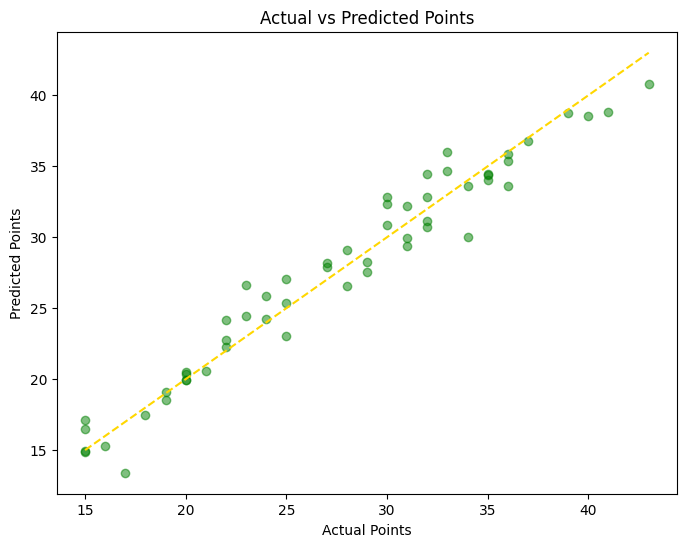

In [288]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='gold', linestyle='--')
plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")
plt.title("Actual vs Predicted Points")
plt.show()

In [289]:
def get_average_stats_against_opponent(df, opponent):
    opponent_column = f"Opp_{opponent}"
    if opponent_column not in df.columns:
        raise ValueError(f"Opponent column {opponent_column} does not exist in the dataset.")
    
    opponent_data = df[df[opponent_column] == 1] 
    average_stats = opponent_data[features].mean() 
    return average_stats

opponent = "OKC"
average_stats = get_average_stats_against_opponent(df, opponent)

game_type = input("Is this a home or away game? ").strip().lower()
if game_type == 'home':
    average_stats['Ven'] = 0
elif game_type == 'away':
    average_stats['Ven'] = 1
else:
    print("Invalid input. Please enter either 'home' or 'away'.")

print(average_stats)


Ven          1.000000
WinMar       0.571429
GS           1.000000
MP          34.941429
FG           9.142857
FGA         19.142857
FG%          0.479143
3P           2.857143
3PA          7.857143
3P%          0.355000
FT           7.857143
FTA          9.000000
FT%          0.878143
ORB          1.571429
DRB          7.142857
TRB          8.714286
AST          3.714286
STL          1.285714
BLK          0.714286
TOV          2.142857
PF           1.857143
GmSc        23.542857
+/-          1.857143
TS%          0.632714
eFG%         0.553714
ORB%         5.157143
DRB%        21.857143
TRB%        13.385714
AST%        17.385714
STL%         1.628571
BLK%         1.485714
TOV%         8.185714
USG%        30.528571
ORtg       126.571429
DRtg       116.857143
BPM          6.457143
Opp_ATL      0.000000
Opp_BRK      0.000000
Opp_CHI      0.000000
Opp_CHO      0.000000
Opp_CLE      0.000000
Opp_DAL      0.000000
Opp_DEN      0.000000
Opp_DET      0.000000
Opp_GSW      0.000000
Opp_HOU   

In [290]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

input_data = average_stats.values.reshape(1, -1) 
input_data_scaled = scaler.transform(input_data)
predicted_points = model.predict(input_data_scaled)

print(f"Predicted points for Jayson Tatum against {opponent}: {predicted_points[0]}")

1/1 [==============================] - 0s 14ms/step
Predicted points for Jayson Tatum against OKC: [30.524313]
